In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

In [49]:
print('Uso de GPU: ',tf.config.list_physical_devices('GPU'))

Uso de GPU:  []


In [50]:
# Hiperparámetros
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
max_seq_length = 100
vocab_size = 10000
dropout_rate = 0.1

In [51]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def positional_encoding(self, position, d_model):
        angles = np.arange(position)[:, np.newaxis] / np.power(
            10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [52]:
def scaled_dot_product_attention(query, key, value, mask=None):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

In [53]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, value, key, query, mask=None):
        batch_size = tf.shape(query)[0]
        
        query = self.wq(query)
        key = self.wk(key)
        value = self.wv(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

In [54]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=True, mask=None):
        attn_output, _ = self.mha(inputs, inputs, inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [55]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, 
                 max_seq_length, dropout_rate=0.1):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_seq_length, d_model)
        
        self.transformer_blocks = [
            TransformerBlock(d_model, num_heads, dff, dropout_rate) 
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs, training=True):
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        
        return self.final_layer(x)

In [56]:
# Generación de datos sintéticos para demostración
def generate_synthetic_data(num_samples, seq_length, vocab_size):
    X = np.random.randint(1, vocab_size, size=(num_samples, seq_length))
    y = np.roll(X, -1, axis=1)
    y[:, -1] = 0  # padding
    return X, y

In [57]:
# Generar datos
num_samples = 10000
X, y = generate_synthetic_data(num_samples, max_seq_length, vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
# Crear y compilar el modelo
model = TransformerModel(num_layers, d_model, num_heads, dff, 
                        vocab_size, max_seq_length, dropout_rate)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.0001,
        decay_steps=10000
    )
)

In [59]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 132s 961ms/step - accuracy: 0.0077 - loss: 9.2087 - val_accuracy: 0.0100 - val_loss: 9.1870
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 883ms/step - accuracy: 0.0100 - loss: 9.1776 - val_accuracy: 0.0100 - val_loss: 9.1727
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 896ms/step - accuracy: 0.0100 - loss: 9.1589 - val_accuracy: 0.0100 - val_loss: 9.1562
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 911ms/step - accuracy: 0.0100 - loss: 9.1365 - val_accuracy: 0.0100 - val_loss: 9.1438
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 911ms/step - accuracy: 0.0100 - loss: 9.1144 - val_accuracy: 0.0100 - val_loss: 9.1379
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 929ms/step - accuracy: 0.0101 - loss: 9.0969 - val_accuracy: 0.0101 - val_loss: 9.1376
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 898ms/step - accuracy: 0.0101 - loss: 9.0852 - val_accuracy: 0.0100 - val_loss: 9.1394
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 905ms/step - accuracy: 0.0101 -

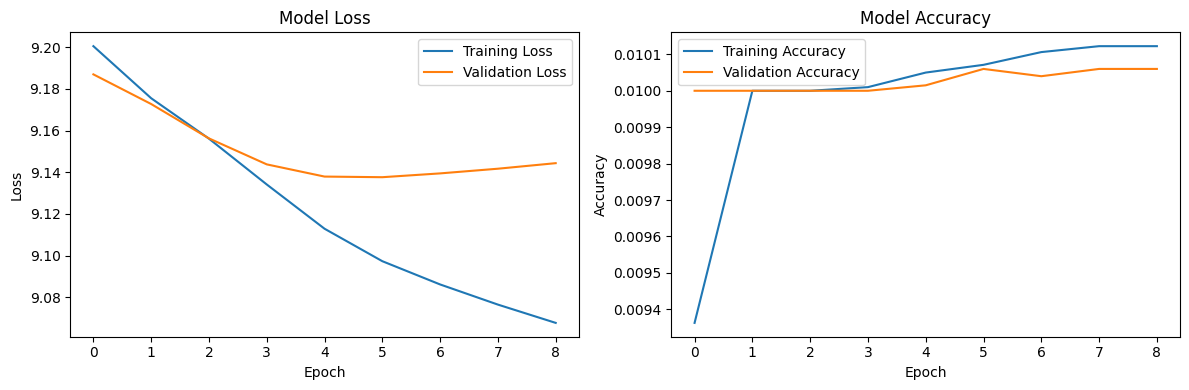

In [61]:
# Visualización del rendimiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Análisis de atención
def plot_attention_weights(attention_weights, layer=0, head=0):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[layer][head], 
                cmap='viridis',
                xticklabels=range(max_seq_length),
                yticklabels=range(max_seq_length))
    plt.title(f'Attention Weights (Layer {layer}, Head {head})')
    plt.xlabel('Key position')
    plt.ylabel('Query position')
    plt.show()